In [66]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, label2rgb
from skimage import data
from skimage.filters import gaussian, sobel, rank
from skimage.segmentation import (morphological_geodesic_active_contour, inverse_gaussian_gradient, active_contour, felzenszwalb, quickshift, watershed,
                                 mark_boundaries, slic, clear_border)

from skimage.future.graph import rag_mean_color, cut_normalized
import io

from scipy import ndimage as ndi
from skimage.morphology import disk

In [67]:
# Helper function to display an image
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))

    ax.imshow(img,cmap=plt.cm.gray)

    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [68]:
# Helper function to compare how good the segmentation is according to the ground truth
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

In [69]:
# Función para calcular la imagen segmentada y su factor_f
def evaluate_image(segmented_image):
    # convertimos la imagen segmentada a escala de grises
    gray_out = rgb2gray(segmented_image)

    # Calculamos el factor f (métrica de éxito) para los diferentes segmentos
    results_eval = [factor_f_evaluation(gray_out==a, gt_image) for a in np.unique(gray_out)]

    # Nos quedamos con aquel factor f que está por encima del 10% (suficientemente grande)
    threshold = .1

    # Inicializamos una imagen a cero del mismo tamaño que la imagen original
    init_image = np.zeros(gray_out.shape)

    # Agregar los segmentos de la imagen con un factor f mayor que el threshold
    for i in range(len(results_eval)):
        if results_eval[i] > threshold:
            init_image = init_image+(gray_out == np.unique(gray_out)[i])
    
    return init_image, factor_f_evaluation(init_image>0,gt_image)

In [70]:
ducks = data.imread('img/ducks01_0100.jpg')
gt_ducks = rgb2gray(data.imread('img/ducks01_0100_gt.ppm'))<1

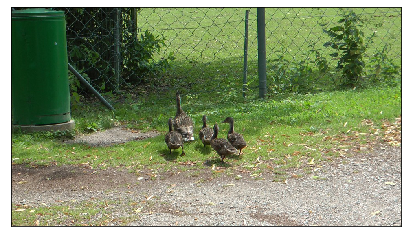

In [71]:
# Image we are going to perform the segmentation operations
imshow(ducks)

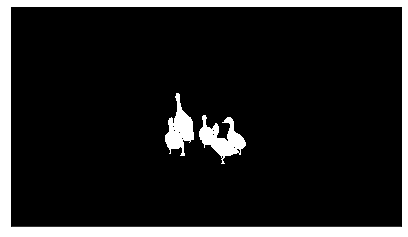

In [73]:
# Ground truth, elements we are trying to crop from the image
imshow(gt_ducks)

## Color based segmentation

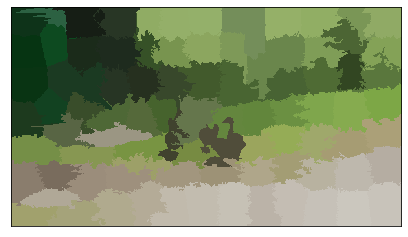

In [10]:
labels1 = slic(ducks, compactness=20, n_segments=100, 
               sigma=.5, multichannel=True)
# For each segment, associate it with its average
out1 = label2rgb(labels1, ducks, kind='avg')
imshow(out1)

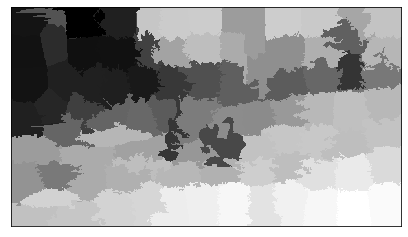

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.32704486367575497, 0.03928980526918671, 0, 0, 0.5903037321682371, 0, 0, 0.005009955681161281, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2859918200408998, 0, 0.015076002990281587, 0, 0, 0.016193291350726127, 0, 0, 0, 0.0005920312592504884, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006028454304316373, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# Convert the values to grayscale
gray_out2 = rgb2gray(out1)
imshow(gray_out2)
# Calculate factor f (success value) for each segment
results_eval = [factor_f_evaluation(gray_out2==a, gt_ducks) for a in np.unique(gray_out2)]
print(results_eval)
# We keep the ones above the threshold
threshold = .1

# Initialize an image with the same size as original
init_image = np.zeros(gray_out2.shape)

# Add each of segments with an f factor above the threshold to that image
for i in range(len(results_eval)):
    if results_eval[i] > threshold:
        init_image = init_image+(gray_out2 == np.unique(gray_out2)[i])

In [13]:
# Calculate f factor of the new segmented image
factor_f_evaluation(init_image>0,gt_ducks)

0.712495078094238

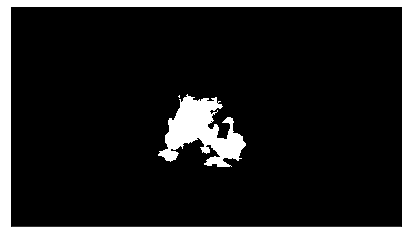

In [14]:
imshow(init_image)

## Felzenszwalb segmentation

In [15]:
segments = felzenszwalb(ducks, scale=50, sigma=4, min_size=38)

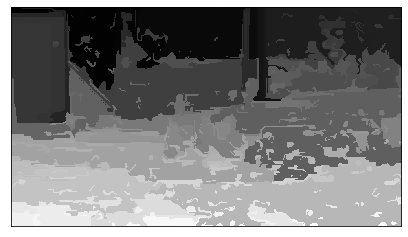

In [16]:
imshow(segments)

In [19]:
gray_out = rgb2gray(segments)

# Calculate factor f (success value) for each segment
results_eval = [factor_f_evaluation(gray_out==a, gt_ducks) for a in np.unique(gray_out)]
print(results_eval)
# We keep the ones above the threshold
threshold = .1

# Initialize an image the same size as the original
init_image = np.zeros(gray_out.shape)

# Add each of segments with an f factor above the threshold to that image
for i in range(len(results_eval)):
    if results_eval[i] > threshold:
        init_image = init_image+(gray_out == np.unique(gray_out)[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0025453388482341707, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08517964071856288, 0, 0.005523908165026757, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.029980410527212332, 0, 0.09908643710470837, 0, 0, 0, 0, 0, 0, 0, 0, 0.49140952709303, 0.04885723749585956, 0, 0, 0.06057046979865771, 0, 0.20149253731343283, 0, 0, 0, 0.002233485095782149, 0, 0.012818458580355713, 0, 0, 0.25163491612169464, 0.0068775790921595595, 0, 0.04907261082924395, 0, 0, 0, 0, 0, 0.005683775404753703, 0, 0, 0.009142659996549939, 0, 0, 0, 0.00861994655633135, 0, 0.003

In [20]:
# Calculate factor f of the new image
factor_f_evaluation(init_image>0,gt_ducks)

0.6909142238742766

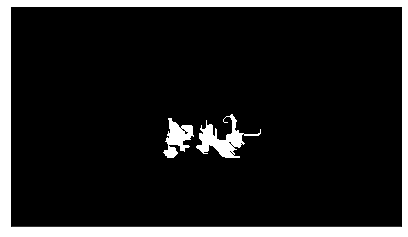

In [21]:
imshow(init_image)

## Quickshift segmentation

In [62]:
segments_quick = quickshift(ducks, kernel_size=5, sigma=10, max_dist=6, ratio=0.4) 

In [63]:
gray_out = rgb2gray(segments_quick)

# Calculate factor f (success value) for each segment
results_eval = [factor_f_evaluation(gray_out==a, gt_ducks) for a in np.unique(gray_out)]
print(results_eval)
# We keep the ones above the threshold
threshold = .1

# Initialize an image the same size as the original
init_image = np.zeros(gray_out.shape)

# Add each of segments with an f factor above the threshold to that image
for i in range(len(results_eval)):
    if results_eval[i] > threshold:
        init_image = init_image+(gray_out == np.unique(gray_out)[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.026842362127867257, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012200312101007233, 0.07166982453249855, 0, 0, 0, 0, 0, 0, 0, 0.09872004357298475, 0, 0, 0.004566557576680112, 0, 0, 0, 0, 0, 0.028957812729678085, 0, 0.2463218565144851, 0, 0, 0, 0, 0.03918780121671802, 0, 0.10128591839974599, 0.010508889368746851, 0, 0, 0, 0, 0, 0, 0, 0, 0.3126894759636206, 0, 0, 0, 0, 0, 0.27782302850796, 0, 0, 0.33090441491641664, 0, 0.010926247827166625, 0, 0, 0.01057656995960338, 0, 0, 0, 0, 0, 0, 0.0485899539098508, 0.02319753705162168, 0, 0, 0, 0, 0, 0.03073670515530981, 0.00031416902293433867, 0, 0, 0, 0, 0, 0.004751619870410368, 0, 0, 0, 0, 0, 0, 0, 0, 0.009412995162766374, 0, 0

In [64]:
# Calculate factor f of the new image
factor_f_evaluation(init_image>0,gt_ducks)

0.8218525051246602

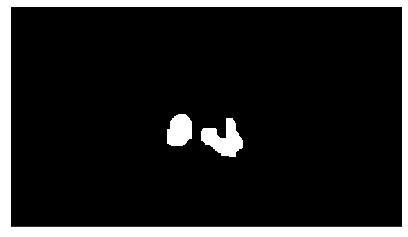

In [65]:
imshow(init_image)

## Morphological Geodesic Active Contour Segmentation

In [36]:
def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))

    return _store

In [43]:
gray_ducks = rgb2gray(ducks)

image = gray_ducks
gimage = inverse_gaussian_gradient(image)

init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1

ls = morphological_geodesic_active_contour(gimage, 350, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

In [40]:
gray_out = rgb2gray(ls)

# Calculate factor f (success value) for each segment
results_eval = [factor_f_evaluation(gray_out==a, gt_ducks) for a in np.unique(gray_out)]
print(results_eval)
# We keep the ones above the threshold
threshold = .1

# Initialize an image the same size as the original
init_image = np.zeros(gray_out.shape)

# Add each of segments with an f factor above the threshold to that image
for i in range(len(results_eval)):
    if results_eval[i] > threshold:
        init_image = init_image+(gray_out == np.unique(gray_out)[i])

[0.01593270274461157, 0.5814099053282216]


In [44]:
# Calculate factor f of the new image
factor_f_evaluation(init_image>0,gt_ducks)

0.5814099053282216

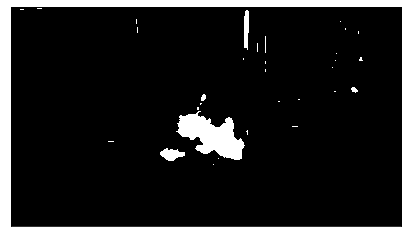

In [46]:
imshow(init_image)

# Segmentación con watershed

In [55]:
def algoritmo_waterShed(patos_grises):
    # Remove the noise with a filter
    denoised = rank.median(rgb2gray(ducks), disk(3))

    # Using a mask for the segmentation
    markers = rank.gradient(denoised, disk(3)) < 30
    markers = ndi.label(markers)[0]

    return watershed(rgb2gray(ducks), markers, compactness=971, watershed_line = False)

/home/dmiranda/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


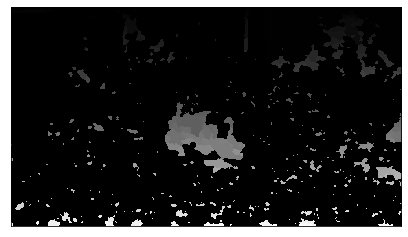

In [56]:
segment_water = algoritmo_waterShed(rgb2gray(ducks))
imshow(segment_water)

In [57]:
gray_out = rgb2gray(segment_water)

# Calculate factor f (success value) for each segment
results_eval = [factor_f_evaluation(gray_out==a, gt_ducks) for a in np.unique(gray_out)]
print(results_eval)
# We keep the ones above the threshold
threshold = .1

# Initialize an image the same size as the original
init_image = np.zeros(gray_out.shape)

# Add each of segments with an f factor above the threshold to that image
for i in range(len(results_eval)):
    if results_eval[i] > threshold:
        init_image = init_image+(gray_out == np.unique(gray_out)[i])

[0, 0, 0.00619731884890207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00017323516673884798, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
# Calculate factor f of the new image
factor_f_evaluation(init_image>0,gt_ducks)

0.5308911667506861

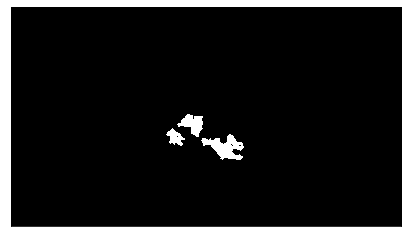

In [60]:
imshow(init_image)